## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

## Reusable Function 

In [2]:
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    results = admin[[variable, 'los']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(admin['los'].loc[admin[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show()

In [3]:
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = admin[[variable, 'los']].groupby(variable).median().reset_index()
    values = list(results['los'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show()

## Read CSV

In [4]:
admin = pd.read_csv("./mimiciv/2.0/hosp/admissions.csv.gz", compression='gzip')
patients = pd.read_csv("./mimiciv/2.0/hosp/patients.csv.gz", compression='gzip')
diagcode = pd.read_csv("./mimiciv/2.0/hosp/diagnoses_icd.csv.gz", compression='gzip')
icu = pd.read_csv("./mimiciv/2.0/icu/icustays.csv.gz", compression='gzip')

## Admission Exploration

In [5]:
admin.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [6]:
admin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [7]:
distinct_admission_type = admin['admission_type'].unique()
print(distinct_admission_type)

['URGENT' 'EW EMER.' 'EU OBSERVATION' 'OBSERVATION ADMIT'
 'SURGICAL SAME DAY ADMISSION' 'AMBULATORY OBSERVATION' 'DIRECT EMER.'
 'DIRECT OBSERVATION' 'ELECTIVE']


In [8]:
print(f"Number of unique admission events: {admin['hadm_id'].nunique()}")
print(f"Number of unique patients: {admin['subject_id'].nunique()}")

Number of unique admission events: 431231
Number of unique patients: 180733


In [9]:
admin.drop(columns=['dischtime','admit_provider_id','edregtime','edouttime','hospital_expire_flag','language','discharge_location'],inplace=True)

In [10]:
admin['deceased']=admin['deathtime'].notnull().map({True:1,False:0})

In [11]:
print(f"{admin['deceased'].sum()} of {admin['subject_id'].nunique()} patients died in hospital.")

8598 of 180733 patients died in hospital.


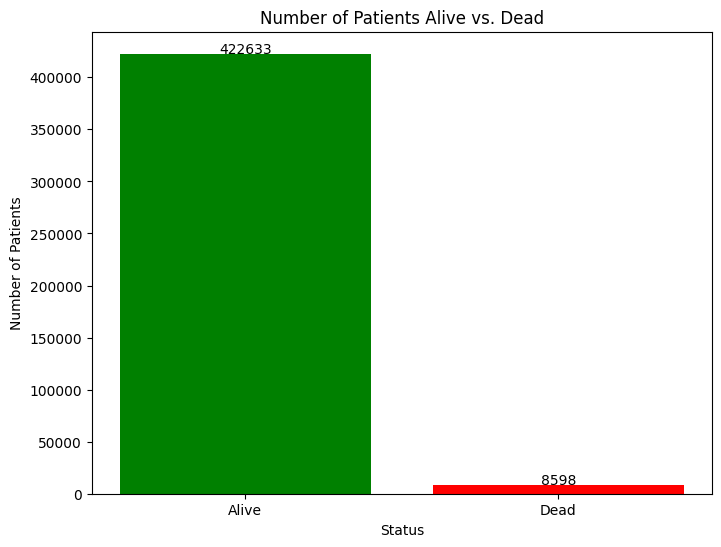

In [12]:
counts = admin['deceased'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(counts.index.map({0: 'Alive', 1: 'Dead'}), counts.values, color=['green', 'red'])
plt.xlabel('Status')
plt.ylabel('Number of Patients')
plt.title('Number of Patients Alive vs. Dead')

# Add counts on top of the bars
for bar, count in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center')

plt.show()

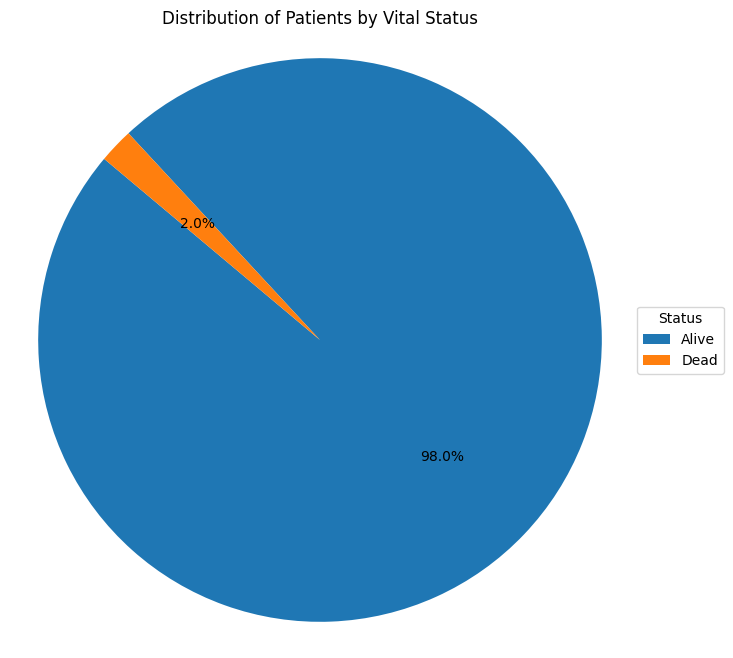

In [13]:
status_labels = {0: 'Alive', 1: 'Dead'}
status_counts = counts.rename(index=status_labels)
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=None, autopct='%1.1f%%', startangle=140)
plt.legend(status_counts.index, title="Status", bbox_to_anchor=(1, 0.5), loc="center left")
plt.title('Distribution of Patients by Vital Status')
plt.axis('equal')

plt.show()

In [14]:
admin = admin[admin['deceased'] == 0]

In [15]:
admin.count()

subject_id            422633
hadm_id               422633
admittime             422633
deathtime                  0
admission_type        422633
admission_location    422633
insurance             422633
marital_status        414511
race                  422633
deceased              422633
dtype: int64

In [16]:
admin['admission_type'].value_counts()

EW EMER.                       144229
EU OBSERVATION                  94702
OBSERVATION ADMIT               51594
URGENT                          43054
SURGICAL SAME DAY ADMISSION     34107
DIRECT EMER.                    19152
DIRECT OBSERVATION              18682
ELECTIVE                        10488
AMBULATORY OBSERVATION           6625
Name: admission_type, dtype: int64

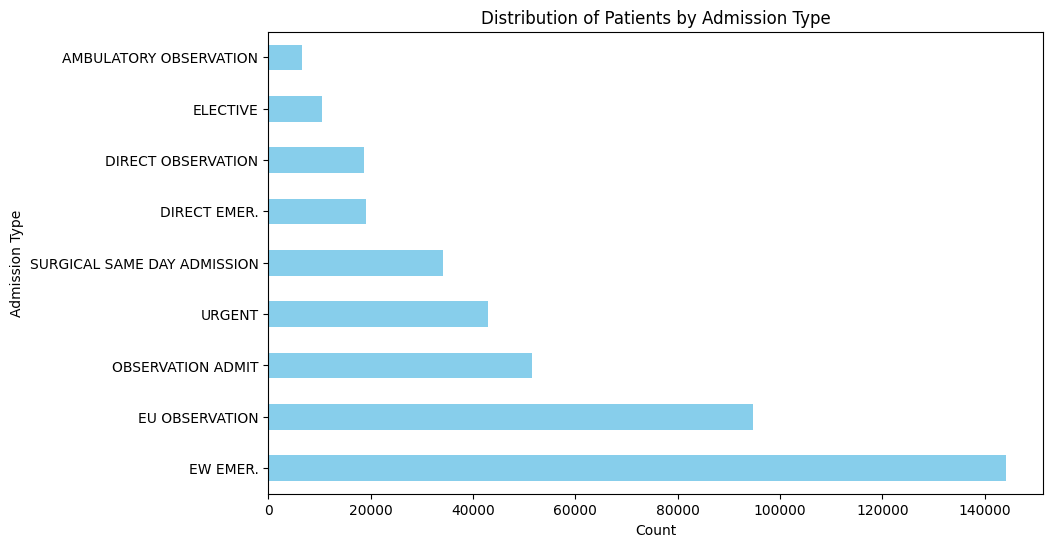

In [17]:
distinct_admission_type = admin['admission_type'].value_counts()

plt.figure(figsize=(10, 6))
distinct_admission_type.plot(kind='barh', color='skyblue')
plt.ylabel('Admission Type')
plt.xlabel('Count')
plt.title('Distribution of Patients by Admission Type')

plt.show()

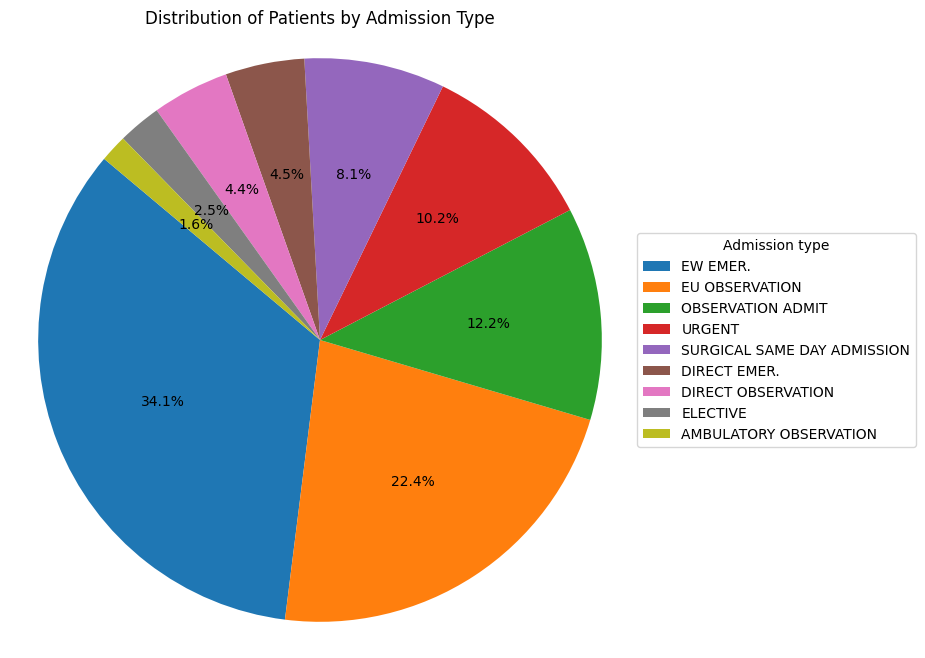

In [18]:
plt.figure(figsize=(8, 8))
plt.pie(distinct_admission_type, labels=None, autopct='%1.1f%%', startangle=140)
plt.legend(distinct_admission_type.index, title="Admission type", bbox_to_anchor=(1, 0.5), loc="center left")
plt.title('Distribution of Patients by Admission Type')
plt.axis('equal')  

plt.show()

In [19]:
admin['admission_location'].value_counts()

EMERGENCY ROOM                            227730
PHYSICIAN REFERRAL                        114044
TRANSFER FROM HOSPITAL                     33937
WALK-IN/SELF REFERRAL                      15647
CLINIC REFERRAL                             9788
PROCEDURE SITE                              7755
PACU                                        5445
INTERNAL TRANSFER TO OR FROM PSYCH          4203
TRANSFER FROM SKILLED NURSING FACILITY      3581
INFORMATION NOT AVAILABLE                    323
AMBULATORY SURGERY TRANSFER                  180
Name: admission_location, dtype: int64

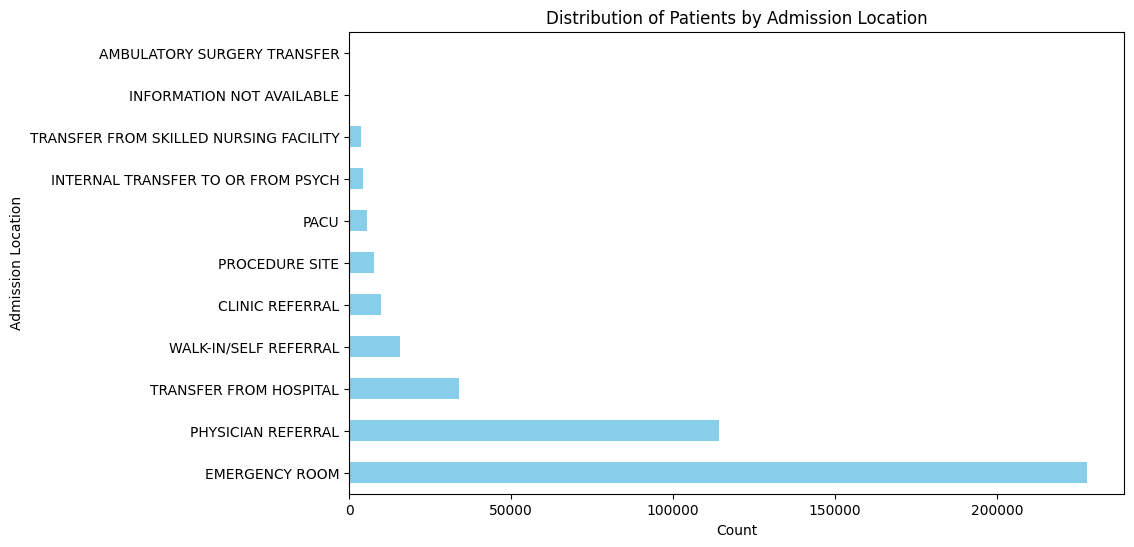

In [20]:
distinct_admission_location = admin['admission_location'].value_counts()

plt.figure(figsize=(10, 6))
distinct_admission_location.plot(kind='barh', color='skyblue')
plt.ylabel('Admission Location')
plt.xlabel('Count')
plt.title('Distribution of Patients by Admission Location')

plt.show()

In [21]:
admin['race'].value_counts()

WHITE                                        267677
BLACK/AFRICAN AMERICAN                        59260
OTHER                                         14855
UNKNOWN                                        9451
HISPANIC/LATINO - PUERTO RICAN                 7992
WHITE - OTHER EUROPEAN                         7779
HISPANIC OR LATINO                             7683
ASIAN                                          6020
ASIAN - CHINESE                                5474
WHITE - RUSSIAN                                4909
BLACK/CAPE VERDEAN                             4727
HISPANIC/LATINO - DOMINICAN                    4342
BLACK/CARIBBEAN ISLAND                         2664
BLACK/AFRICAN                                  2504
PATIENT DECLINED TO ANSWER                     1735
PORTUGUESE                                     1483
UNABLE TO OBTAIN                               1462
ASIAN - SOUTH EAST ASIAN                       1410
HISPANIC/LATINO - GUATEMALAN                   1320
ASIAN - ASIA

In [22]:
admin['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
admin['race'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
admin['race'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
admin['race'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
admin['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                      'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)

top_5_races = admin['race'].value_counts().nlargest(5).index.tolist()

admin.loc[~admin['race'].isin(top_5_races), 'race'] = 'OTHER/UNKNOWN'

admin['race'].value_counts()

WHITE                     282607
BLACK/AFRICAN AMERICAN     69155
OTHER/UNKNOWN              31311
HISPANIC/LATINO            24976
ASIAN                      14584
Name: race, dtype: int64

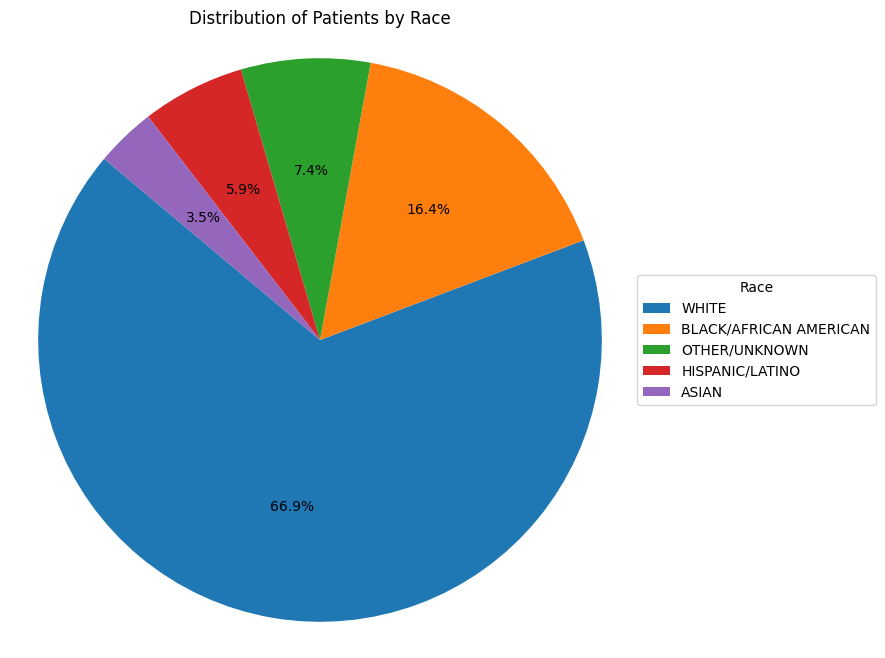

In [23]:
race_count=admin['race'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(race_count, labels=None, autopct='%1.1f%%', startangle=140)
plt.legend(race_count.index, title="Race", bbox_to_anchor=(1, 0.5), loc="center left")
plt.title('Distribution of Patients by Race')
plt.axis('equal')  

plt.show()

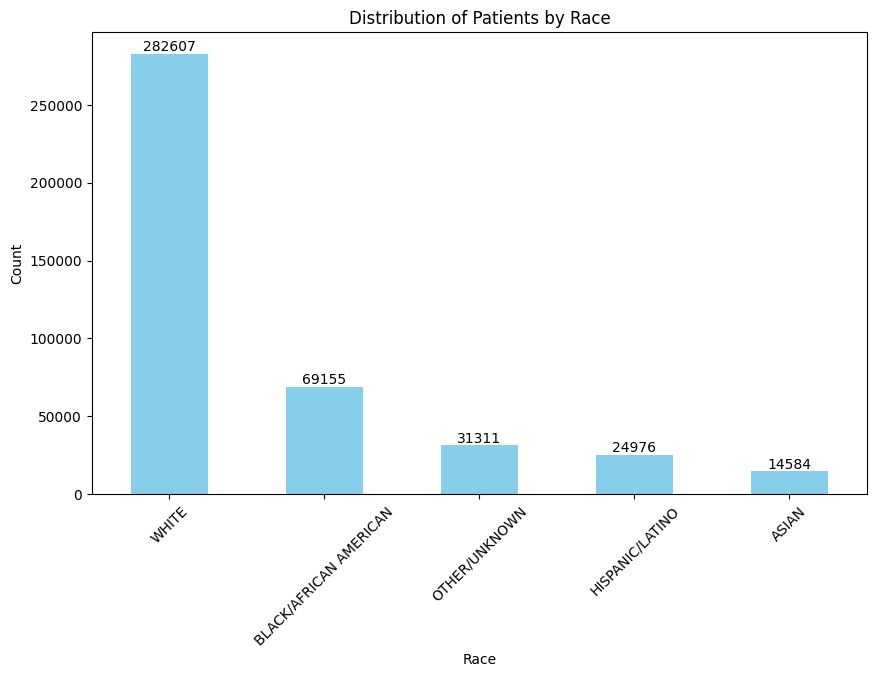

In [24]:
plt.figure(figsize=(10, 6))
ax = race_count.plot(kind='bar', color='skyblue')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Patients by Race')
plt.xticks(rotation=45)  

for i, count in enumerate(race_count):
    ax.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

In [25]:
admin['insurance'].value_counts()

Other       225941
Medicare    155839
Medicaid     40853
Name: insurance, dtype: int64

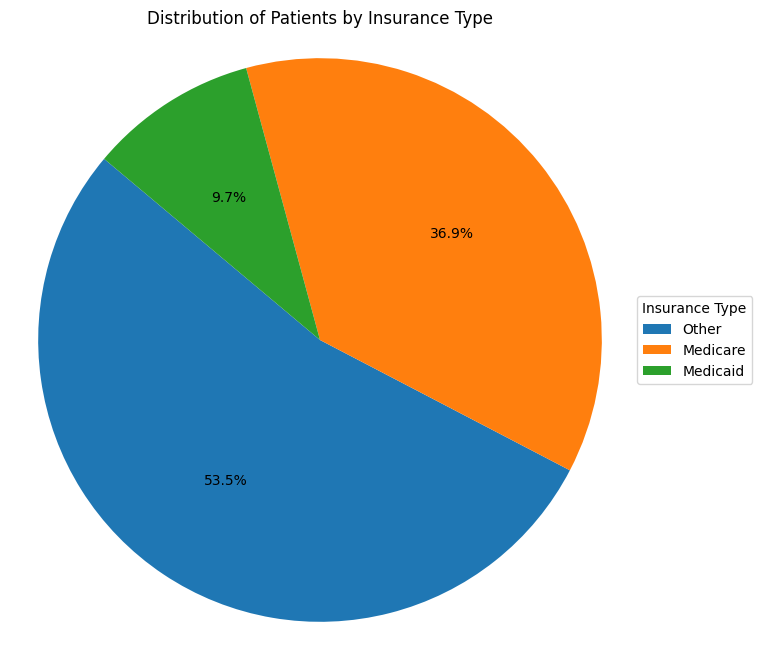

In [26]:
ins_count=admin['insurance'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(ins_count, labels=None, autopct='%1.1f%%', startangle=140)
plt.legend(ins_count.index, title="Insurance Type", bbox_to_anchor=(1, 0.5), loc="center left")
plt.title('Distribution of Patients by Insurance Type')
plt.axis('equal')  

plt.show()

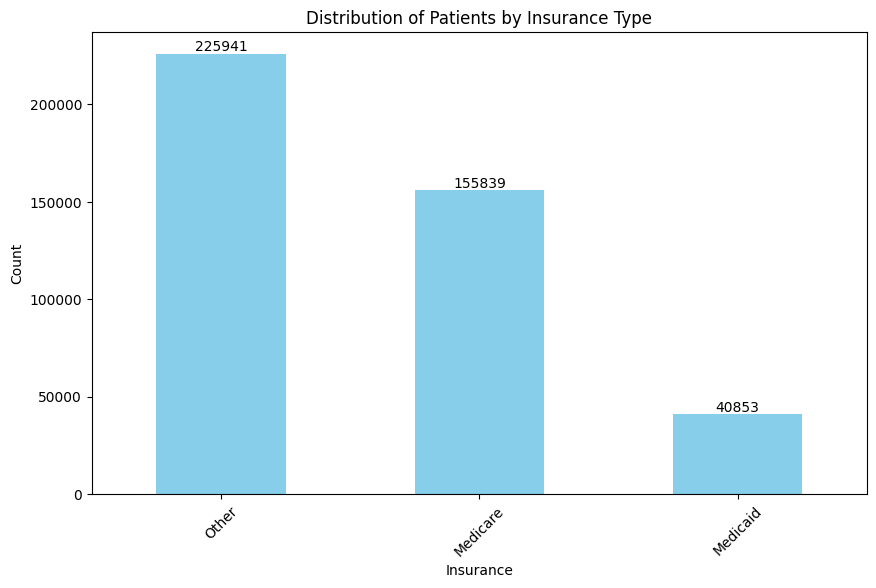

In [27]:
plt.figure(figsize=(10, 6))
ax = ins_count.plot(kind='bar', color='skyblue')
plt.xlabel('Insurance')
plt.ylabel('Count')
plt.title('Distribution of Patients by Insurance Type')
plt.xticks(rotation=45)  

for i, count in enumerate(ins_count):
    ax.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

In [28]:
admin['marital_status'].value_counts()

MARRIED     177705
SINGLE      161363
WIDOWED      44319
DIVORCED     31124
Name: marital_status, dtype: int64

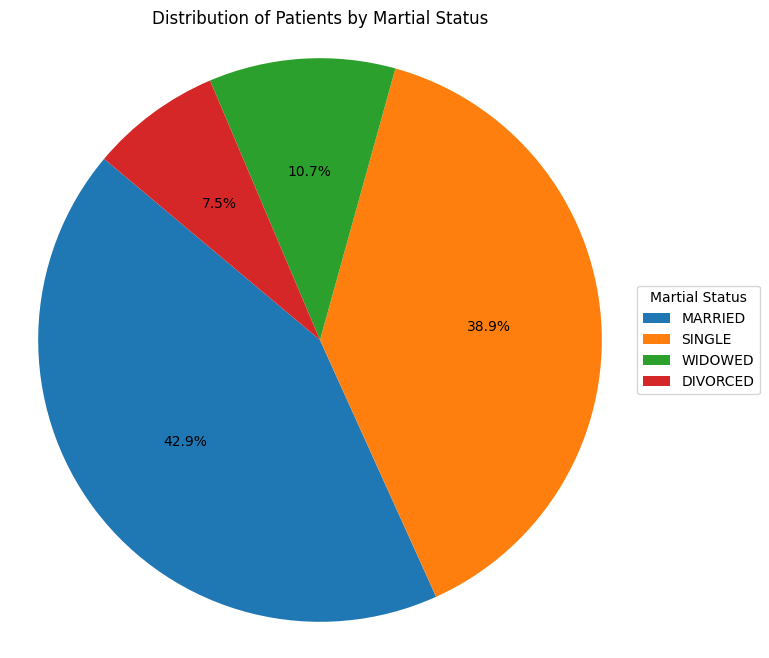

In [29]:
marital_count=admin['marital_status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(marital_count, labels=None, autopct='%1.1f%%', startangle=140)
plt.legend(marital_count.index, title="Martial Status", bbox_to_anchor=(1, 0.5), loc="center left")
plt.title('Distribution of Patients by Martial Status')
plt.axis('equal')  

plt.show()

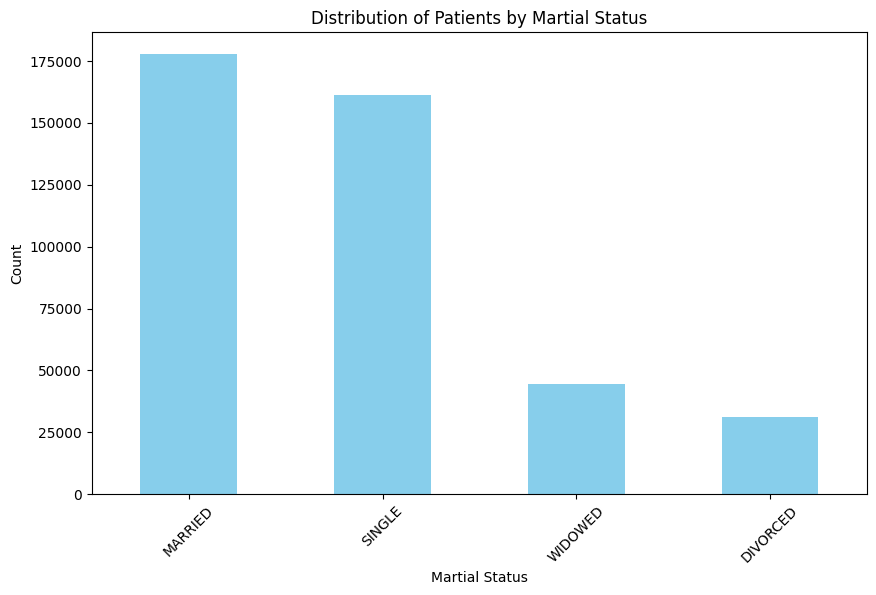

In [30]:
plt.figure(figsize=(10, 6))
ax = marital_count.plot(kind='bar', color='skyblue')
plt.xlabel('Martial Status')
plt.ylabel('Count')
plt.title('Distribution of Patients by Martial Status')
plt.xticks(rotation=45)  


plt.show()

## Diagnosis Exploration

In [31]:
diagcode.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [32]:
diagcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


In [33]:
print(f"There are {diagcode[diagcode['icd_version']==9].value_counts().count()} unique ICD9 codes in this dataset.")

There are 2766877 unique ICD9 codes in this dataset.


It's not feasible to use 2766877 unique values as labels for predicting Disease, we need to reduce the diagnosis into more general categories. Hence, I will convert ICD9 codes into super categories as the following:

- 001–139: infectious and parasitic diseases
- 140–239: neoplasms
- 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
- 280–289: diseases of the blood and blood-forming organs
- 290–319: mental disorders
- 320–389: diseases of the nervous system and sense organs
- 390–459: diseases of the circulatory system
- 460–519: diseases of the respiratory system
- 520–579: diseases of the digestive system
- 580–629: diseases of the genitourinary system
- 630–679: complications of pregnancy, childbirth, and the puerperium
- 680–709: diseases of the skin and subcutaneous tissue
- 710–739: diseases of the musculoskeletal system and connective tissue
- 740–759: congenital anomalies
- 760–779: certain conditions originating in the perinatal period
- 780–799: symptoms, signs, and ill-defined conditions
- 800–999: injury and poisoning
- E and V codes: external causes of injury and supplemental classification

In [34]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
diagcode['recode'] = diagcode['icd_code']
diagcode['recode'] = diagcode['recode'][~diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
diagcode['recode'].fillna(value='999', inplace=True)

In [35]:
diagcode['recode'] = diagcode['recode'].str.slice(start=0, stop=3, step=1)
diagcode['recode'] = diagcode['recode'].astype(int)

In [36]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diagcode['recode'] = np.where(diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, diagcode['recode'])
    
# Convert integer to category name using diag_dict
diagcode['recode'] = diagcode['recode']
diagcode['cat'] = diagcode['recode'].replace(diag_dict)

In [37]:
diagcode.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,cat
0,10000032,22595853,1,5723,9,8,digestive
1,10000032,22595853,2,78959,9,15,misc
2,10000032,22595853,3,5715,9,8,digestive
3,10000032,22595853,4,07070,9,0,infectious
4,10000032,22595853,5,496,9,7,respiratory


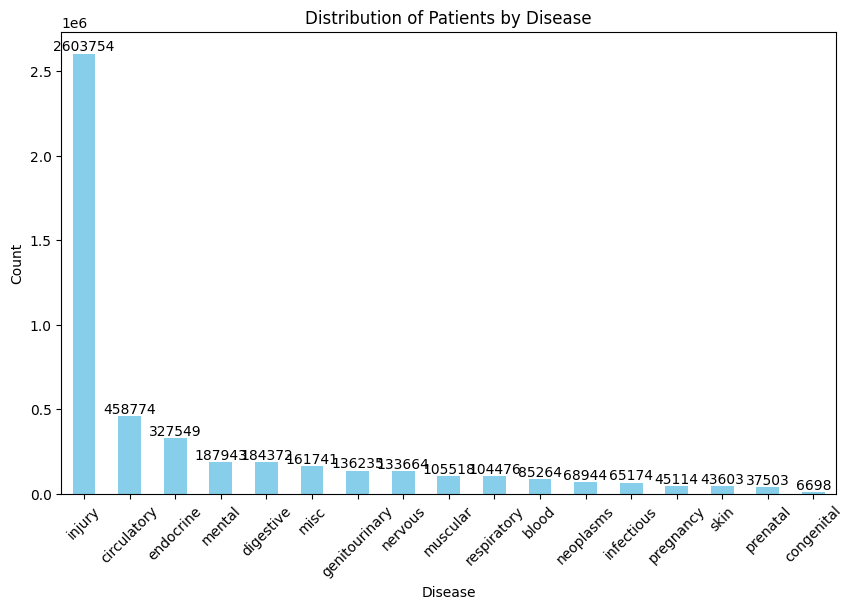

In [38]:
disease_counts = diagcode['cat'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
disease_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Distribution of Patients by Disease')
plt.xticks(rotation=45)

for i, count in enumerate(disease_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')
plt.show()

In [39]:
hadm_list = diagcode.groupby('subject_id')['cat'].apply(list).reset_index()
hadm_list.head()

,subject_id,cat
0,10000032,"[digestive, misc, digestive, infectious, respi..."
1,10000068,[mental]
2,10000084,"[injury, injury, injury, injury, injury, injur..."
3,10000108,"[digestive, digestive]"
4,10000117,"[injury, injury, injury, injury, injury, injur..."


In [40]:
#one hot encoding
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item[hadm_item >= 1] = 1
hadm_item.head()

C:\Users\ys\AppData\Local\Temp\ipykernel_12324\3128520363.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [41]:
# Join back with subject_id, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['subject_id'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,subject_id
0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,0,10000032
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10000068
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10000084
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10000108
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10000117


In [42]:
admin = admin.merge(hadm_item, how='inner', on='subject_id')

In [43]:
admin.head()

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,insurance,marital_status,race,deceased,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,2180-05-06 22:23:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Other,WIDOWED,WHITE,0,...,1,1,1,0,0,0,0,0,1,0
1,10000032,22841357,2180-06-26 18:27:00,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WIDOWED,WHITE,0,...,1,1,1,0,0,0,0,0,1,0
2,10000032,25742920,2180-08-05 23:44:00,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WIDOWED,WHITE,0,...,1,1,1,0,0,0,0,0,1,0
3,10000032,29079034,2180-07-23 12:35:00,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WIDOWED,WHITE,0,...,1,1,1,0,0,0,0,0,1,0
4,10000068,25022803,2160-03-03 23:16:00,NaN,EU OBSERVATION,EMERGENCY ROOM,Other,SINGLE,WHITE,0,...,0,1,0,0,0,0,0,0,0,0


## Patient Exploration

In [44]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [45]:
distinct_patients = patients['anchor_age'].unique()
print(distinct_patients)

[52 23 19 72 27 25 24 48 59 34 20 63 81 22 30 53 32 74 29 86 18 54 80 65
 73 40 70 64 46 55 28 43 89 35 71 47 21 62 84 68 87 31 77 26 37 75 39 56
 58 57 38 69 79 33 44 45 60 91 42 82 78 66 61 51 85 76 88 49 41 50 36 67
 83]


In [46]:
patients['gender'].value_counts()

F    158553
M    141159
Name: gender, dtype: int64

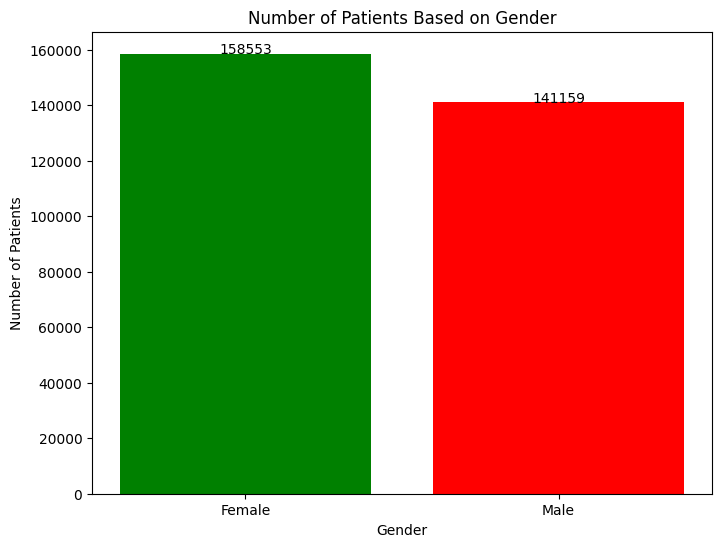

In [47]:
counts = patients['gender'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(counts.index.map({'F': 'Female', 'M': 'Male'}), counts.values, color=['green', 'red'])
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.title('Number of Patients Based on Gender')

# Add counts on top of the bars
for bar, count in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center')

plt.show()

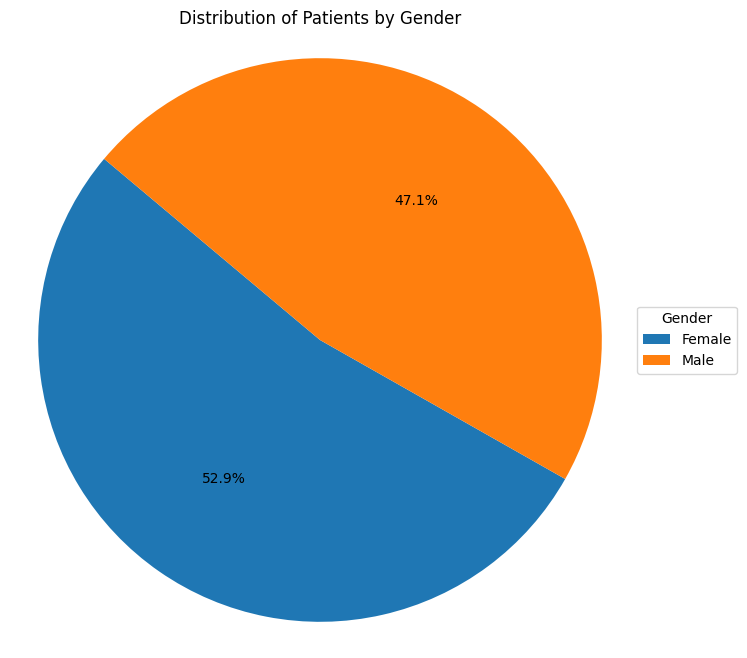

In [48]:
status_labels = {'F': 'Female', 'M': 'Male'}
status_counts = counts.rename(index=status_labels)
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=None, autopct='%1.1f%%', startangle=140)
plt.legend(status_counts.index, title="Gender", bbox_to_anchor=(1, 0.5), loc="center left")
plt.title('Distribution of Patients by Gender')
plt.axis('equal')

plt.show()

In [49]:
# Convert to datetime type
patients['dod'] = pd.to_datetime(patients['dod'])

In [50]:
patients = patients[['subject_id', 'anchor_age', 'gender']]
patients.head()

,subject_id,anchor_age,gender
0,10000032,52,F
1,10000048,23,F
2,10000068,19,F
3,10000084,72,M
4,10000102,27,F


In [51]:
admin = admin.merge(patients, how='inner', on='subject_id')

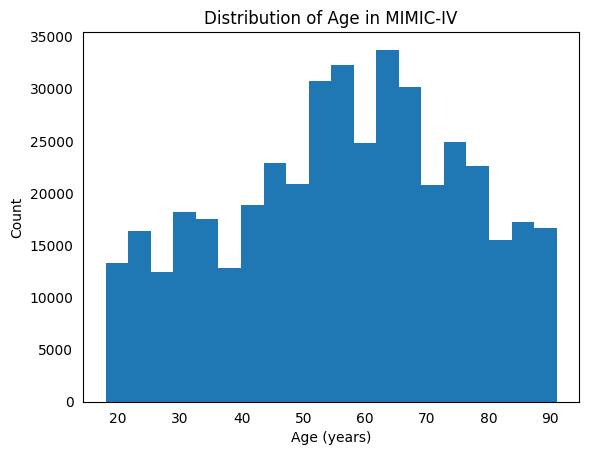

In [52]:
plt.hist(admin['anchor_age'], bins=20)
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

In [53]:
admin.rename(columns={'anchor_age': 'age'}, inplace=True)

In [54]:
#replace gender with binary
admin['gender'].replace({'M': 0, 'F':1}, inplace=True)

## ICUSTAYS Exploration

In [55]:
icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73181 entries, 0 to 73180
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      73181 non-null  int64  
 1   hadm_id         73181 non-null  int64  
 2   stay_id         73181 non-null  int64  
 3   first_careunit  73181 non-null  object 
 4   last_careunit   73181 non-null  object 
 5   intime          73181 non-null  object 
 6   outtime         73181 non-null  object 
 7   los             73181 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 4.5+ MB


In [56]:
icu['stay_id'].nunique()

73181

In [57]:
# Merge ICU data with main dataFrame
admin = admin.merge(icu[['stay_id','subject_id']], how='inner', on='subject_id')
admin.head()

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,insurance,marital_status,race,deceased,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,age,gender,stay_id
0,10000032,22595853,2180-05-06 22:23:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Other,WIDOWED,WHITE,0,...,0,0,0,0,0,1,0,52,1,39553978
1,10000032,22841357,2180-06-26 18:27:00,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WIDOWED,WHITE,0,...,0,0,0,0,0,1,0,52,1,39553978
2,10000032,25742920,2180-08-05 23:44:00,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WIDOWED,WHITE,0,...,0,0,0,0,0,1,0,52,1,39553978
3,10000032,29079034,2180-07-23 12:35:00,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WIDOWED,WHITE,0,...,0,0,0,0,0,1,0,52,1,39553978
4,10000980,20897796,2193-08-15 01:01:00,NaN,OBSERVATION ADMIT,WALK-IN/SELF REFERRAL,Other,MARRIED,BLACK/AFRICAN AMERICAN,0,...,1,0,1,0,0,1,0,73,1,39765666


In [58]:
admin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388950 entries, 0 to 388949
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subject_id          388950 non-null  int64 
 1   hadm_id             388950 non-null  int64 
 2   admittime           388950 non-null  object
 3   deathtime           0 non-null       object
 4   admission_type      388950 non-null  object
 5   admission_location  388950 non-null  object
 6   insurance           388950 non-null  object
 7   marital_status      383341 non-null  object
 8   race                388950 non-null  object
 9   deceased            388950 non-null  int64 
 10  blood               388950 non-null  uint64
 11  circulatory         388950 non-null  uint64
 12  congenital          388950 non-null  uint64
 13  digestive           388950 non-null  uint64
 14  endocrine           388950 non-null  uint64
 15  genitourinary       388950 non-null  uint64
 16  in

# Data Preprocessing

In [59]:
admin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388950 entries, 0 to 388949
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subject_id          388950 non-null  int64 
 1   hadm_id             388950 non-null  int64 
 2   admittime           388950 non-null  object
 3   deathtime           0 non-null       object
 4   admission_type      388950 non-null  object
 5   admission_location  388950 non-null  object
 6   insurance           388950 non-null  object
 7   marital_status      383341 non-null  object
 8   race                388950 non-null  object
 9   deceased            388950 non-null  int64 
 10  blood               388950 non-null  uint64
 11  circulatory         388950 non-null  uint64
 12  congenital          388950 non-null  uint64
 13  digestive           388950 non-null  uint64
 14  endocrine           388950 non-null  uint64
 15  genitourinary       388950 non-null  uint64
 16  in

In [60]:
admin.to_csv('./data/preprocessing/diagnosis_unfiltered.csv.gz',index = False )

In [61]:
df = pd.read_csv('./data/preprocessing/diagnosis_unfiltered.csv.gz')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388950 entries, 0 to 388949
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   subject_id          388950 non-null  int64  
 1   hadm_id             388950 non-null  int64  
 2   admittime           388950 non-null  object 
 3   deathtime           0 non-null       float64
 4   admission_type      388950 non-null  object 
 5   admission_location  388950 non-null  object 
 6   insurance           388950 non-null  object 
 7   marital_status      383341 non-null  object 
 8   race                388950 non-null  object 
 9   deceased            388950 non-null  int64  
 10  blood               388950 non-null  int64  
 11  circulatory         388950 non-null  int64  
 12  congenital          388950 non-null  int64  
 13  digestive           388950 non-null  int64  
 14  endocrine           388950 non-null  int64  
 15  genitourinary       388950 non-nul

In [63]:
# Remove deceased persons
df = df[df['deceased'] == 0]

In [64]:
df.drop(columns=['race','deceased','subject_id', 'hadm_id', 'admittime', 'admission_location','admission_type','insurance', 'marital_status'
                ,'deathtime'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388950 entries, 0 to 388949
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   blood          388950 non-null  int64
 1   circulatory    388950 non-null  int64
 2   congenital     388950 non-null  int64
 3   digestive      388950 non-null  int64
 4   endocrine      388950 non-null  int64
 5   genitourinary  388950 non-null  int64
 6   infectious     388950 non-null  int64
 7   injury         388950 non-null  int64
 8   mental         388950 non-null  int64
 9   misc           388950 non-null  int64
 10  muscular       388950 non-null  int64
 11  neoplasms      388950 non-null  int64
 12  nervous        388950 non-null  int64
 13  pregnancy      388950 non-null  int64
 14  prenatal       388950 non-null  int64
 15  respiratory    388950 non-null  int64
 16  skin           388950 non-null  int64
 17  age            388950 non-null  int64
 18  gender         388950 no

In [65]:
df.drop_duplicates(subset=['stay_id'], keep='first', inplace=True)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69328 entries, 0 to 388949
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   blood          69328 non-null  int64
 1   circulatory    69328 non-null  int64
 2   congenital     69328 non-null  int64
 3   digestive      69328 non-null  int64
 4   endocrine      69328 non-null  int64
 5   genitourinary  69328 non-null  int64
 6   infectious     69328 non-null  int64
 7   injury         69328 non-null  int64
 8   mental         69328 non-null  int64
 9   misc           69328 non-null  int64
 10  muscular       69328 non-null  int64
 11  neoplasms      69328 non-null  int64
 12  nervous        69328 non-null  int64
 13  pregnancy      69328 non-null  int64
 14  prenatal       69328 non-null  int64
 15  respiratory    69328 non-null  int64
 16  skin           69328 non-null  int64
 17  age            69328 non-null  int64
 18  gender         69328 non-null  int64
 19  sta

In [67]:
#data from LoS Prediction
processed_data=pd.read_csv('./data/preprocessing/processed_data.csv.gz')

In [68]:
#drop columns that are binary, repeated or not important
processed_data.drop(columns=['Orientation', 'Temperature',
                             'Base Excess','Amikacin','Cyclosporin'], inplace=True)

In [69]:
processed_data.head()

,stay_id,Anion Gap,Bicarbonate,"Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Free Calcium,Glucose,H,...,GCS - Motor Response,GCS - Verbal Response,Heart Rate,Inspired O2 Fraction,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,O2 saturation pulseoxymetry,Respiratory Rate,Temperature Fahrenheit
0,30000153,12.000000,21.000000,7.700000,22.666667,115.000000,1.000000,1.1300,169.000000,0.000000,...,5.875000,3.458333,104.804878,51.000000,69.960000,86.320000,142.360000,97.500000,14.875000,99.316667
1,30000213,15.666667,23.333333,8.333333,27.000000,100.666667,3.666667,0.0000,203.500000,26.333333,...,5.818182,3.636364,82.736842,45.000000,57.400000,80.228571,136.142857,97.947368,18.868421,98.618182
2,30000484,10.000000,27.666667,8.133333,33.000000,105.000000,1.233333,0.0000,106.666667,0.000000,...,4.933333,3.066667,91.881356,0.000000,62.118644,74.677966,118.338983,99.881356,17.644068,97.368750
3,30000646,12.000000,22.125000,7.625000,21.000000,109.500000,0.742857,1.1100,107.250000,0.000000,...,6.000000,5.000000,94.046667,100.000000,61.125000,68.361111,94.486111,95.693333,24.526667,98.430000
4,30001148,10.500000,27.666667,0.000000,28.111111,106.666667,0.700000,1.2475,122.363636,0.000000,...,5.285714,3.857143,74.592593,43.333333,56.250000,68.125000,105.625000,98.481481,14.758621,97.630000


In [70]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72030 entries, 0 to 72029
Data columns (total 58 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stay_id                                72030 non-null  int64  
 1   Anion Gap                              72030 non-null  float64
 2   Bicarbonate                            72030 non-null  float64
 3   Calcium, Total                         72030 non-null  float64
 4   Calculated Total CO2                   72030 non-null  float64
 5   Chloride                               72030 non-null  float64
 6   Creatinine                             72030 non-null  float64
 7   Free Calcium                           72030 non-null  float64
 8   Glucose                                72030 non-null  float64
 9   H                                      72030 non-null  float64
 10  Hematocrit                             72030 non-null  float64
 11  He

In [71]:
final_data = processed_data.merge(df, on='stay_id', how='inner')

In [72]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68383 entries, 0 to 68382
Data columns (total 77 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stay_id                                68383 non-null  int64  
 1   Anion Gap                              68383 non-null  float64
 2   Bicarbonate                            68383 non-null  float64
 3   Calcium, Total                         68383 non-null  float64
 4   Calculated Total CO2                   68383 non-null  float64
 5   Chloride                               68383 non-null  float64
 6   Creatinine                             68383 non-null  float64
 7   Free Calcium                           68383 non-null  float64
 8   Glucose                                68383 non-null  float64
 9   H                                      68383 non-null  float64
 10  Hematocrit                             68383 non-null  float64
 11  He

In [73]:
final_data.drop(columns=['gender_x', 'anchor_age','stay_id','los'], inplace=True)

final_data.rename(columns={'gender_y': 'gender'}, inplace=True)

In [74]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68383 entries, 0 to 68382
Data columns (total 73 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Anion Gap                              68383 non-null  float64
 1   Bicarbonate                            68383 non-null  float64
 2   Calcium, Total                         68383 non-null  float64
 3   Calculated Total CO2                   68383 non-null  float64
 4   Chloride                               68383 non-null  float64
 5   Creatinine                             68383 non-null  float64
 6   Free Calcium                           68383 non-null  float64
 7   Glucose                                68383 non-null  float64
 8   H                                      68383 non-null  float64
 9   Hematocrit                             68383 non-null  float64
 10  Hemoglobin                             68383 non-null  float64
 11  He

In [75]:
final_data.to_csv('./data/dataset/disease.csv.gz',index=False)

In [76]:
final_data=pd.read_csv('./data/dataset/disease.csv.gz')

C:\Users\ys\AppData\Local\Temp\ipykernel_12324\333561745.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_data['gender'] = gender_data['gender'].map({0: 'Male', 1: 'Female'})


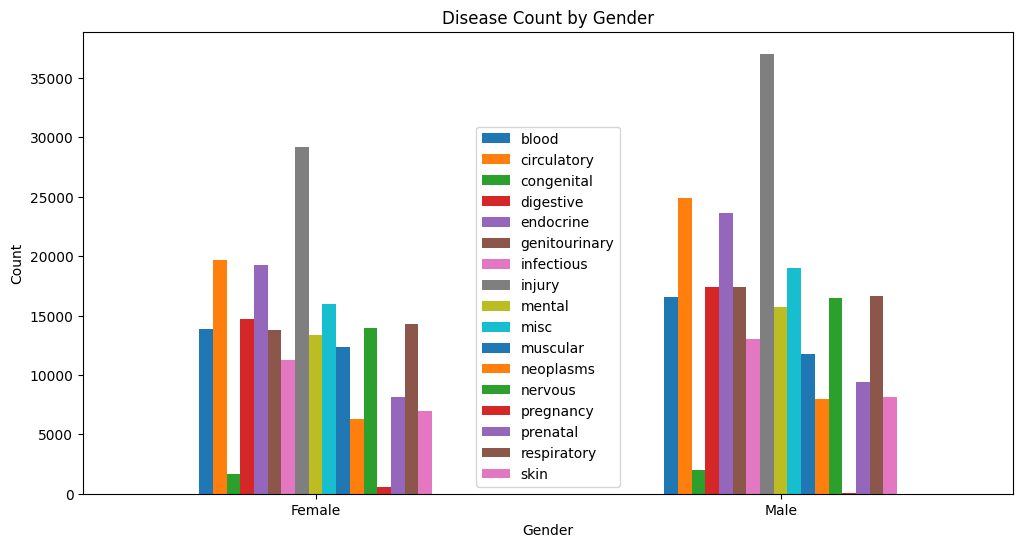

In [77]:
gender_data = final_data[['gender', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary',
                             'infectious', 'injury', 'mental', 'misc', 'muscular', 'neoplasms', 'nervous', 'pregnancy',
                             'prenatal', 'respiratory', 'skin']]

gender_data['gender'] = gender_data['gender'].map({0: 'Male', 1: 'Female'})

gender_grouped = gender_data.groupby('gender').sum()

gender_grouped.plot(kind='bar', figsize=(12, 6))
plt.title('Disease Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0) 

plt.show()

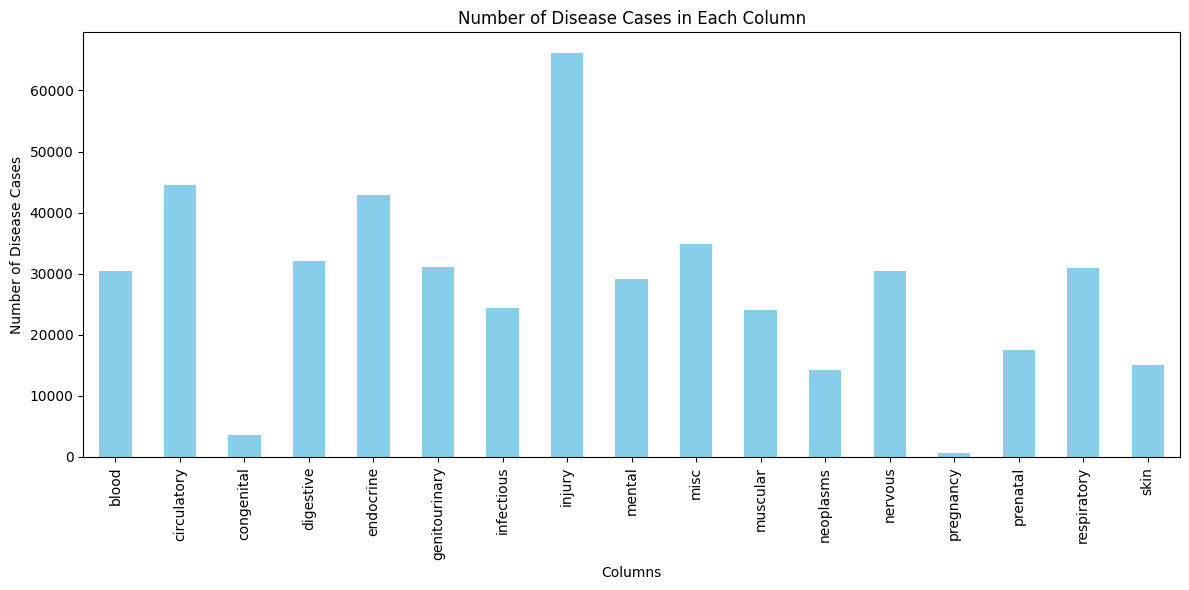

In [78]:
df = final_data[['blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary',
                             'infectious', 'injury', 'mental', 'misc', 'muscular', 'neoplasms', 'nervous', 'pregnancy',
                             'prenatal', 'respiratory', 'skin']]
disease_counts = df.astype(bool).sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
disease_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Disease Cases')
plt.title('Number of Disease Cases in Each Column')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

# Disease Prediction Model

In [79]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import Normalizer,MinMaxScaler, StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split

In [81]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain

In [7]:
df=pd.read_csv('./data/dataset/disease.csv.gz')

In [110]:
#pregnancy is not a disease
df.drop(columns=['pregnancy'], inplace =True)

In [111]:
# Target Variable 
label_columns = ['blood', 'circulatory','congenital','digestive','endocrine', 'genitourinary','infectious'
                ,'injury','mental','misc','muscular','neoplasms','nervous','prenatal','respiratory','skin']
targets = df[label_columns] 
# Prediction Features
features = df.drop(columns=label_columns)

In [112]:
# This custom function extends scikit-learn's train_test_split to handle multi-label data and 
# maintain class distribution during the split

def multilabel_train_test_split(*arrays,
                                test_size=None,
                                train_size=None,
                                random_state=None,
                                shuffle=True,
                                stratify=None):
    # checks if the stratify parameter is None. If it is, this means that the user hasn't specified a stratification 
    # strategy for multi-label data.
    
    if stratify is None:
        return train_test_split(*arrays, test_size=test_size,train_size=train_size,
                                random_state=random_state, stratify=None, shuffle=shuffle)
    
    # checks if the shuffle parameter is set to True. 
    # If not, it raises an assertion error because stratified train/test splitting is not 
    # implemented when shuffling is turned off.
    
    assert shuffle, "Stratified train/test split is not implemented for shuffle=False"
    
    # These lines determine the number of input arrays (n_arrays) and ensure that all input arrays are indexable.
    
    n_arrays = len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    
    # This line calculates the sizes of the training and testing sets using the _validate_shuffle_split function. 
    # It uses the provided test_size, train_size, and a default test size of 0.25 if not specified.
    
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    
    # This line initializes a MultilabelStratifiedShuffleSplit object 
    # with the determined test and train sizes and a random seed of 123.
    # ensuring that each label's distribution is preserved.
    
    cv = MultilabelStratifiedShuffleSplit(test_size=n_test, train_size=n_train, random_state=123)
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )

In [113]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = multilabel_train_test_split(features, 
                                                    targets, 
                                                    test_size = .20, stratify=targets)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 54733 samples.
Testing set has 13650 samples.


In [114]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (54733, 56)
X_test: (13650, 56)
y_train: (54733, 16)
y_test: (13650, 16)


In [115]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [116]:
X_train_scaled.shape

(54733, 56)

In [89]:
classifiers = [
    RandomForestClassifier(random_state=42),
    MultinomialNB(),
    LogisticRegression(max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    SVC(random_state=42)
]

results = {
    'Classifier': [],
    'Accuracy': [],
    'Hamming Loss': [],
    'Classification Report': []
}

for classifier in classifiers:
    print(f"Classifier: {classifier.__class__.__name__}")

    # Create a pipeline for each classifier
    clf_chain = ClassifierChain(classifier=classifier, require_dense=[True, True])

    # Train the classifier chain
    clf_chain.fit(X_train_scaled, y_train)

    # Predict labels for the test set
    y_pred = clf_chain.predict(X_test_scaled)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)

    # Generate classification report
    class_report = classification_report(y_test, y_pred, zero_division=0)

    # Store the results in the dictionary
    results['Classifier'].append(classifier.__class__.__name__)
    results['Accuracy'].append(acc)
    results['Hamming Loss'].append(hamming)
    results['Classification Report'].append(class_report)

    # Print the accuracy for the current model
    print(f"Accuracy: {acc:.2f}")
    print(f"Hamming Loss: {hamming:.2f}\n")
    print(f"Classification Report: \n{class_report}\n")

Classifier: RandomForestClassifier
Accuracy: 0.30
Hamming Loss: 0.22

Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      6094
           1       0.92      0.83      0.87      8913
           2       0.00      0.00      0.00       727
           3       0.74      0.71      0.72      6430
           4       0.88      0.82      0.85      8577
           5       0.76      0.75      0.75      6234
           6       0.64      0.73      0.68      4863
           7       0.97      1.00      0.98     13241
           8       0.64      0.71      0.68      5819
           9       0.77      0.73      0.75      6988
          10       0.55      0.65      0.60      4814
          11       0.61      0.26      0.37      2858
          12       0.66      0.70      0.68      6081
          13       0.44      0.56      0.49      3503
          14       0.74      0.75      0.74      6193
          15       0.42      0.67      0.

## Model Evaluation

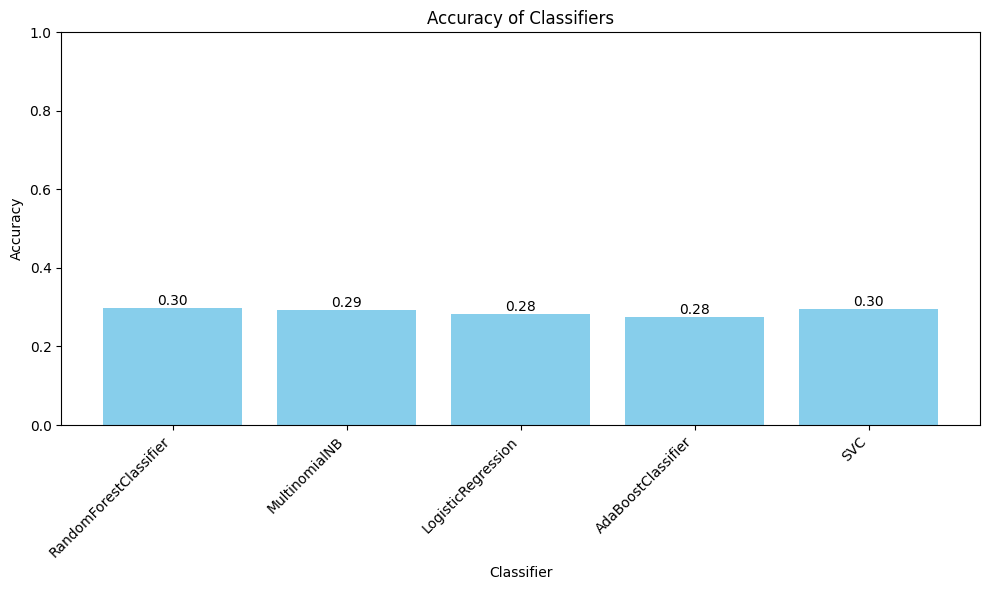

In [90]:
classifiers = results['Classifier']
accuracy_scores = results['Accuracy']

plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracy_scores, color='skyblue')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Classifiers')
plt.xticks(rotation=45, ha='right') 
plt.ylim(0, 1)  

for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

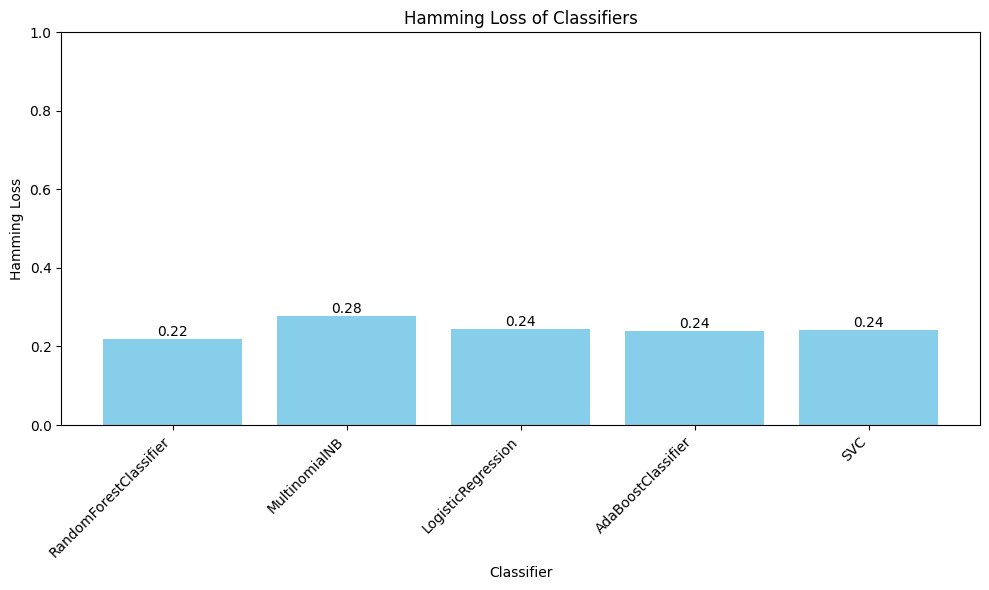

In [94]:
hamming_loss = results['Hamming Loss']

plt.figure(figsize=(10, 6))
plt.bar(classifiers, hamming_loss, color='skyblue')
plt.xlabel('Classifier')
plt.ylabel('Hamming Loss')
plt.title('Hamming Loss of Classifiers')
plt.xticks(rotation=45, ha='right') 
plt.ylim(0, 1)  

for i, acc in enumerate(hamming_loss):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Without ML-SMOTE

In [117]:
#RandomForestClassifier is chosen among the 5 models as the best
model =  RandomForestClassifier(random_state=42)

# Create a pipeline for each classifier
clf_chain = ClassifierChain(classifier=model, require_dense=[True, True])

# Train the classifier chain
clf_chain.fit(X_train_scaled, y_train)

# Predict labels for the test set
y_pred = clf_chain.predict(X_test_scaled)

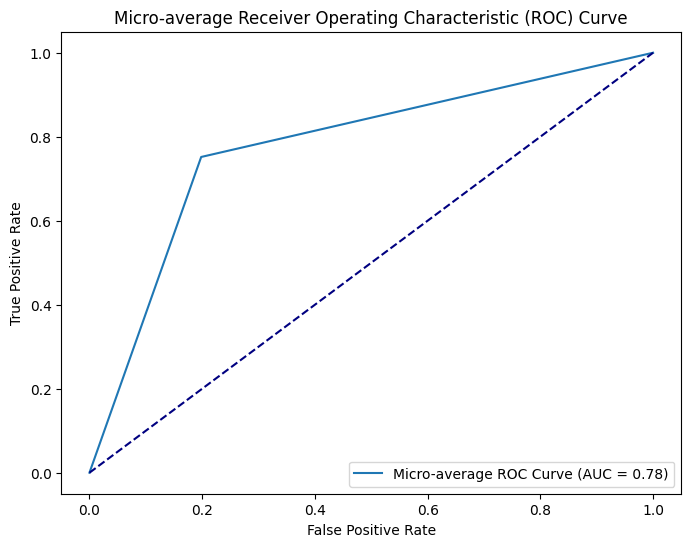

In [120]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming y_pred and y_test are in sparse matrix format
y_test_array = y_test.values.ravel()
y_pred_array = y_pred.toarray().ravel()  # Convert y_pred to a dense array

# Calculate the false positive rate, true positive rate, and thresholds for the micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_array, y_pred_array)

# Calculate the micro-average ROC AUC score
roc_auc_micro = roc_auc_score(y_test_array, y_pred_array)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC Curve (AUC = {:.2f})'.format(roc_auc_micro))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### With ML-SMOTE

In [121]:
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
import random

In [122]:
#Give tail label columns of the given target dataframe
def get_tail_label(df):
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

# give the index of all tail_label rows
def get_index(df):
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

# Give minority dataframe containing all the tail labels
def get_minority_instace(X, y):
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

# Give index of 5 nearest neighbor of all the instance
def nearest_neighbour(X):

    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

#Give the augmented data using MLSMOTE algorithm
def MLSMOTE(X,y, n_sample):
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target


In [126]:
X_sub, y_sub = get_minority_instace(X_train, y_train)   #Getting minority instance of that datframe
X_res,y_res =MLSMOTE(X_sub, y_sub, 1000)     #Applying MLSMOTE to augment the dataframe
print("ORIGINAL\n", y_train.sum())
print("\nAFTER\n",y_res.sum())

ORIGINAL
 blood            24376
circulatory      35651
congenital        2907
digestive        25719
endocrine        34305
genitourinary    24934
infectious       19451
injury           52961
mental           23273
misc             27951
muscular         19256
neoplasms        11433
nervous          24325
prenatal         14012
respiratory      24770
skin             12054
dtype: int64

AFTER
 blood            18780.0
circulatory      24209.0
congenital        2940.0
digestive        19410.0
endocrine        23779.0
genitourinary    18928.0
infectious       15986.0
injury           25429.0
mental           17217.0
misc             21331.0
muscular         15007.0
neoplasms        11860.0
nervous          18627.0
prenatal         14625.0
respiratory      18588.0
skin             12552.0
dtype: float64


In [128]:
# Initialize MinMaxScaler
from sklearn.preprocessing import Normalizer,MinMaxScaler, StandardScaler,RobustScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

In [129]:
from sklearn.metrics import accuracy_score, hamming_loss
model =  RandomForestClassifier(random_state=42)

# Create a pipeline for each classifier
smote_clf_chain = ClassifierChain(classifier=model, require_dense=[True, True])

# Train the classifier chain
smote_clf_chain.fit(X_train_scaled, y_res)

# Predict labels for the test set
y_pred = smote_clf_chain.predict(X_test_scaled)

#calculate evaluation metrics
smoteAcc = accuracy_score(y_test, y_pred)
smoteHamming = hamming_loss(y_test, y_pred)

# Generate classification report
smote_class_report = classification_report(y_test, y_pred, zero_division=0)

# Print the accuracy for the current model
print(f"Accuracy: {smoteAcc:.2f}")
print(f"Hamming Loss: {smoteHamming:.2f}\n")
print(f"Classification Report: \n{smote_class_report}\n")

Accuracy: 0.03
Hamming Loss: 0.39

Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.90      0.68      6094
           1       0.66      1.00      0.79      8913
           2       0.32      0.01      0.02       727
           3       0.53      0.92      0.67      6430
           4       0.64      1.00      0.78      8577
           5       0.54      0.93      0.68      6234
           6       0.45      0.91      0.60      4863
           7       0.97      1.00      0.98     13241
           8       0.47      0.92      0.62      5819
           9       0.54      0.96      0.69      6988
          10       0.40      0.88      0.55      4814
          11       0.37      0.53      0.44      2858
          12       0.48      0.95      0.63      6081
          13       0.27      0.95      0.42      3503
          14       0.53      0.93      0.67      6193
          15       0.27      0.90      0.42      3013

   micro avg       0.

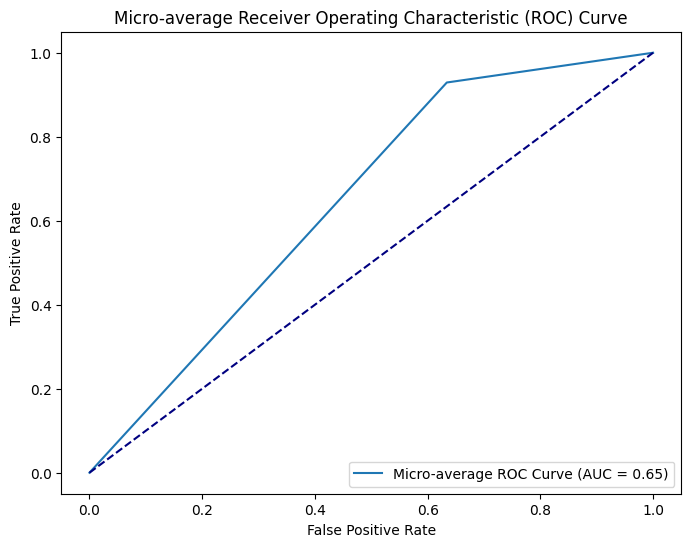

In [130]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming y_pred and y_test are in sparse matrix format
y_test_array = y_test.values.ravel()
y_pred_array = y_pred.toarray().ravel()  # Convert y_pred to a dense array

# Calculate the false positive rate, true positive rate, and thresholds for the micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_array, y_pred_array)

# Calculate the micro-average ROC AUC score
roc_auc_micro = roc_auc_score(y_test_array, y_pred_array)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC Curve (AUC = {:.2f})'.format(roc_auc_micro))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Based on this we observed that Random Forest Classifier without Sampling has a higher AUC value which is 0.78

### SAVED MODEL

In [132]:
#save the model
import pickle

filename = './data/model/disease_model.sav'
with open(filename, 'wb') as file:
    pickle.dump(clf_chain, file)